Saved summary: sim_outputs\summary_table.csv


C:\Users\mzarreh\AppData\Local\Temp\ipykernel_25184\164937734.py:220: UserWarning: FigureCanvasAgg is non-interactive, and thus cannot be shown
  fig.show()
C:\Users\mzarreh\AppData\Local\Temp\ipykernel_25184\164937734.py:227: UserWarning: FigureCanvasAgg is non-interactive, and thus cannot be shown
  fig.show()
C:\Users\mzarreh\AppData\Local\Temp\ipykernel_25184\164937734.py:234: UserWarning: FigureCanvasAgg is non-interactive, and thus cannot be shown
  fig.show()
C:\Users\mzarreh\AppData\Local\Temp\ipykernel_25184\164937734.py:229: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`). Consider using `matplotlib.pyplot.close()`.
  fig, ax = plt.subplots(figsize=(6,3))


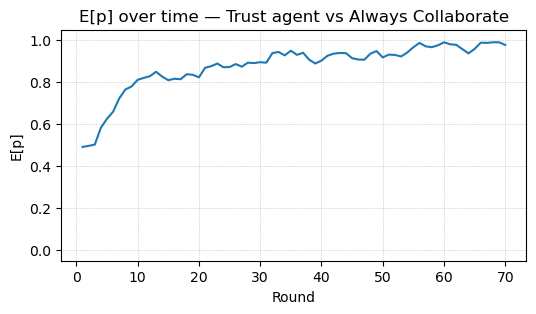

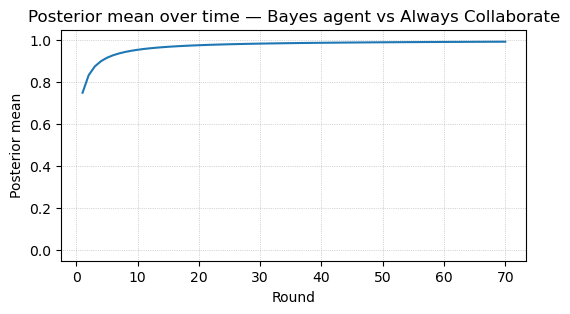

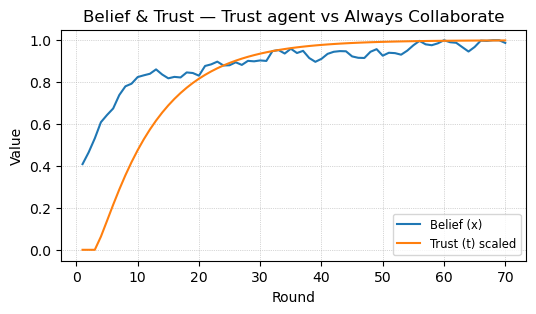

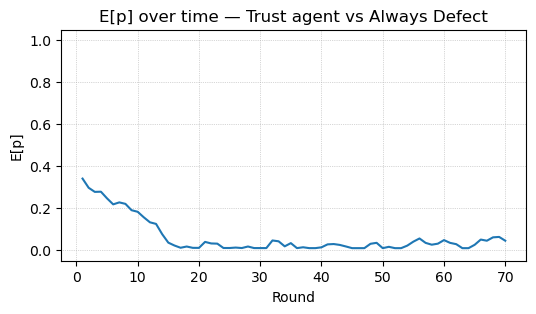

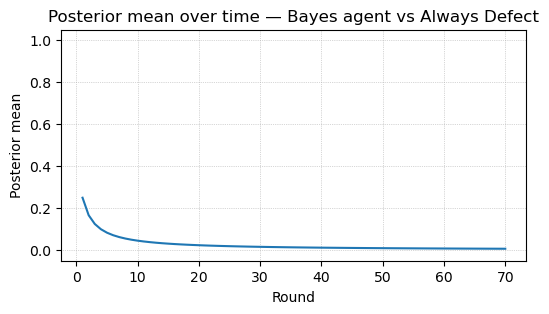

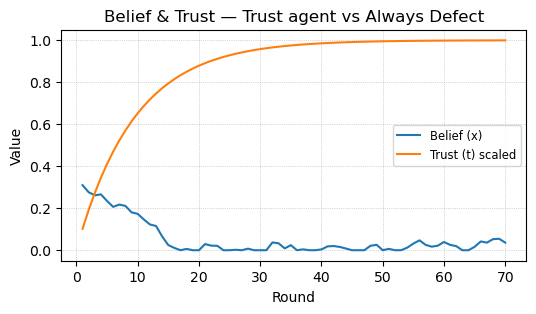

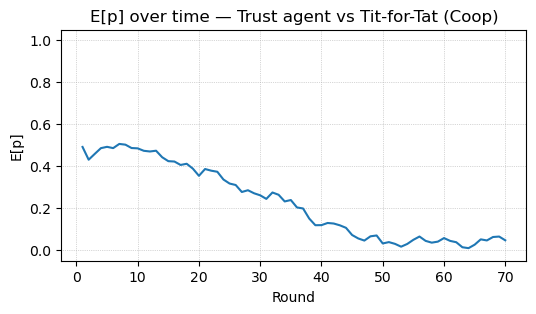

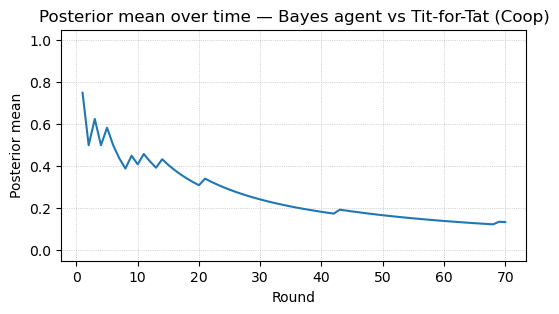

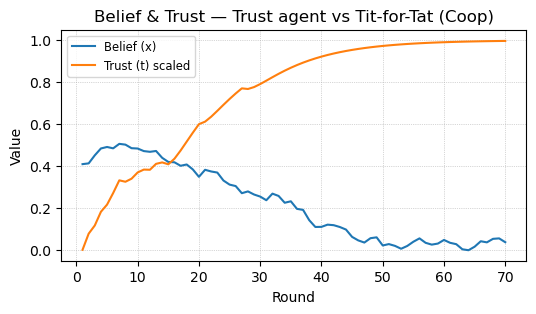

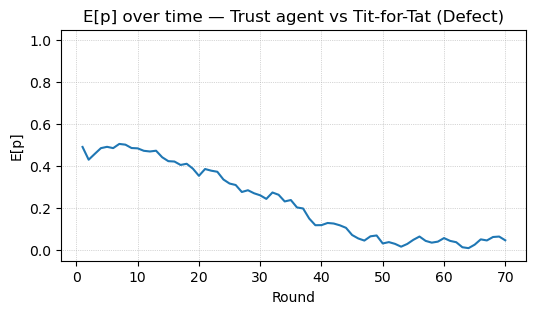

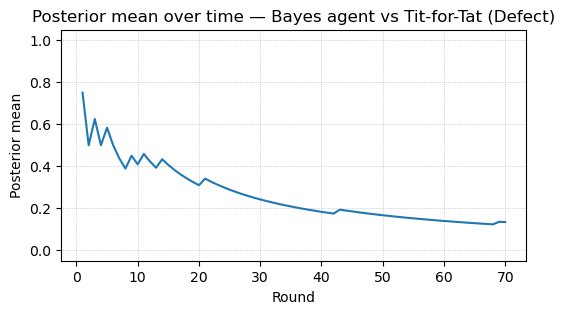

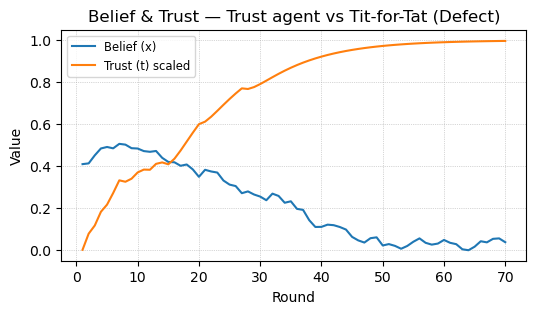

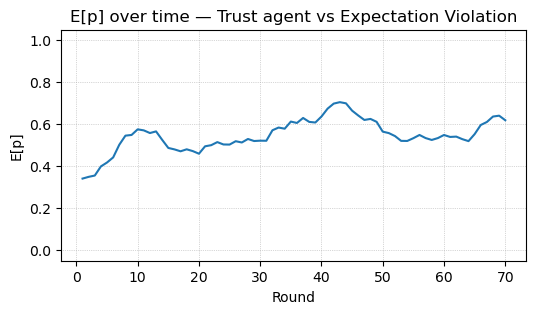

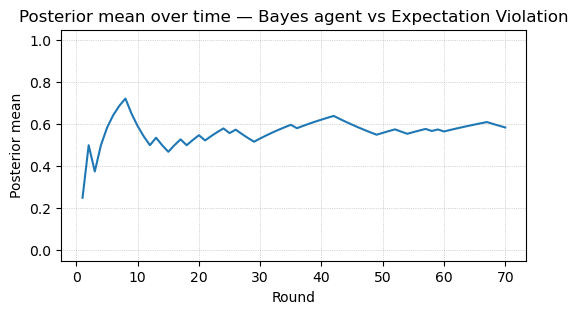

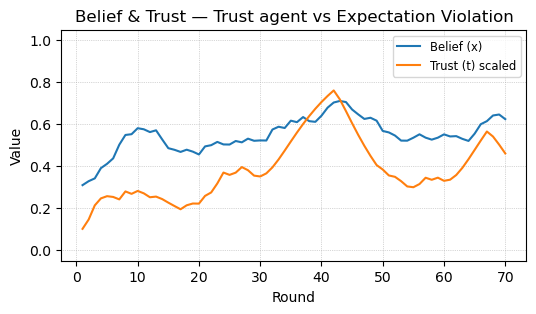

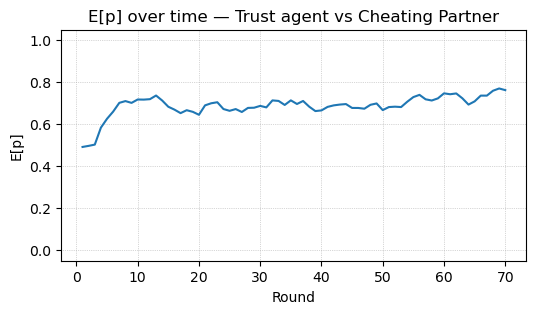

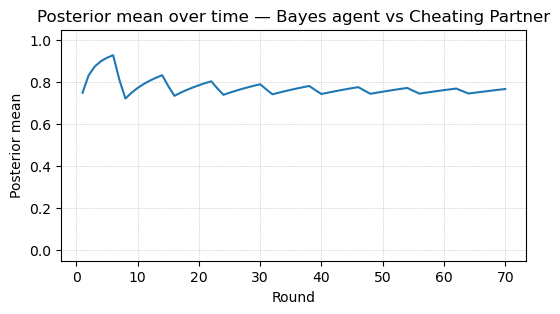

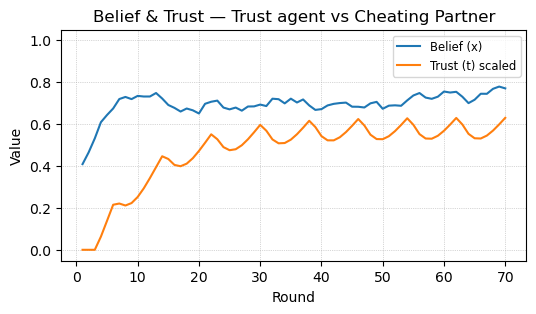

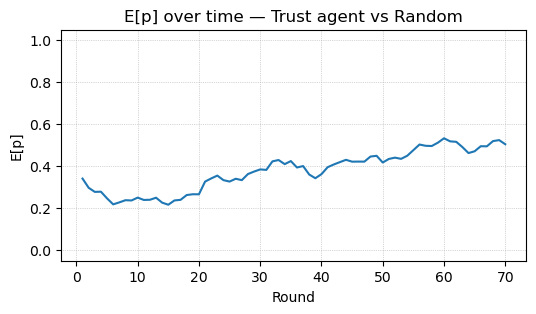

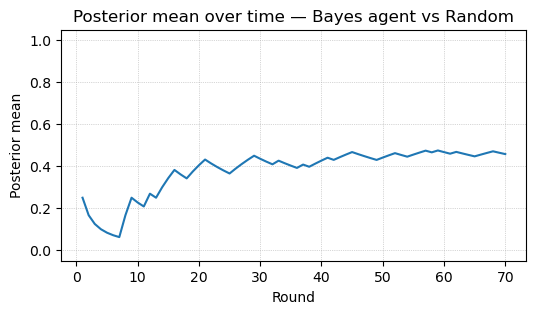

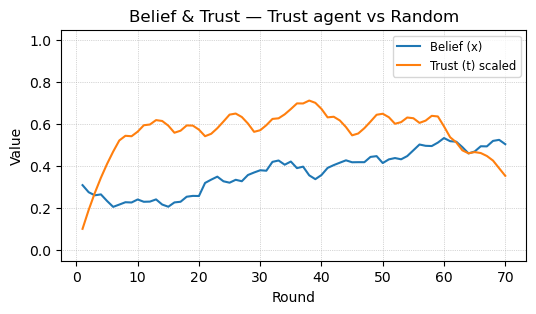

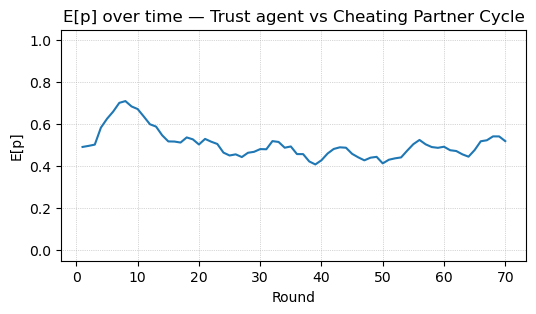

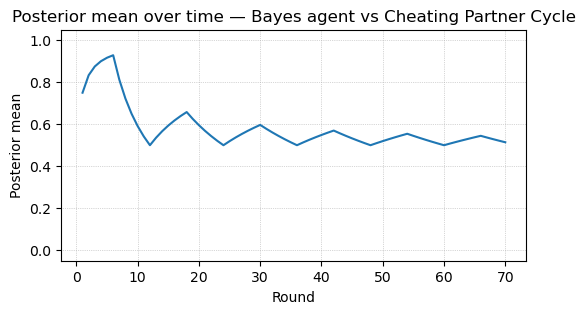

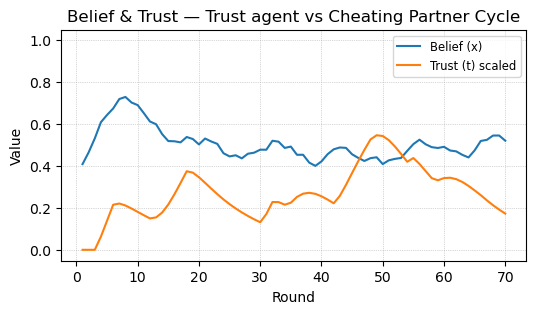

In [2]:
# Simulation + plotting for the 8 selected partners
# Copy-paste and run in your Python environment (Jupyter recommended)

import numpy as np
import random
import pandas as pd
import matplotlib.pyplot as plt
import os

# ---------- Payoff matrix & helpers ----------
payoff = np.array([[[2,2],[3,0]], [[0,3],[4,4]]])
def get_payoff(p1, p2, pid): return payoff[int(p1), int(p2), int(pid)]
a00 = get_payoff(0,0,0); a01 = get_payoff(0,1,0)
a10 = get_payoff(1,0,0); a11 = get_payoff(1,1,0)
def stag_indifference_threshold():
    den = (a00 - a10) + (a11 - a01)
    return float((a00 - a10)/den) if den != 0 else 0.5

EPS = 0.5
DEFAULTS = {"TRUST_MIN":0.1, "TRUST_MAX":50.0, "MEMORY_DISCOUNT":0.9, "TRUST_DISCOUNT":0.6, "TRUST_SMOOTHING":0.1}

# ---------- Trust-based focal agent ----------
class FocalAgent:
    def __init__(self, u_i=None, t_init=0.1, eta=0.1, noise_sigma=0.02,
                 memory_discount=DEFAULTS["MEMORY_DISCOUNT"],
                 trust_discount=DEFAULTS["TRUST_DISCOUNT"],
                 trust_smoothing=DEFAULTS["TRUST_SMOOTHING"],
                 stochastic=True, inv_temp=2.0, loss_aversion=3.0, lambda_surprise=0.5):
        self.x = u_i if u_i is not None else 1 - stag_indifference_threshold()
        self.t = t_init
        self.eta = eta; self.noise_sigma = noise_sigma
        self.memory_discount = memory_discount; self.trust_discount = trust_discount
        self.trust_smoothing = trust_smoothing; self.stochastic = stochastic
        self.inv_temp = inv_temp; self.loss_aversion = loss_aversion; self.lambda_surprise = lambda_surprise
        self.trust_match_hist=[]; self.trust_betrayal_hist=[]; self.trust_surprise_hist=[]
        self.action_history=[]

    def expected_p(self):
        alpha = EPS + self.x * self.t
        beta  = EPS + (1 - self.x) * self.t
        return alpha / (alpha + beta)

    def make_decision(self):
        p = self.expected_p()
        EV_hare = (1 - p) * a00 + p * a01
        EV_stag = (1 - p) * a10 + p * a11
        D = EV_stag - EV_hare
        if not self.stochastic: return 1 if D > 0 else 0
        prob_stag = 1.0 / (1.0 + np.exp(-self.inv_temp * D))
        return 1 if random.random() < prob_stag else 0

    def compute_new_trust(self, partner_choice):
        expected = 1 if self.x > 0.5 else 0
        obs = int(partner_choice)
        is_match = 1.0 if (obs == expected) else 0.0
        is_betrayal = 1.0 if (expected == 1 and obs == 0) else 0.0
        is_surprise = 1.0 if (expected == 0 and obs == 1) else 0.0

        M = (self.trust_match_hist + [is_match]) if self.trust_match_hist else [is_match]
        B = (self.trust_betrayal_hist + [is_betrayal]) if self.trust_betrayal_hist else [is_betrayal]
        U = (self.trust_surprise_hist + [is_surprise]) if self.trust_surprise_hist else [is_surprise]

        wM = [self.trust_discount ** (len(M)-1-i) for i in range(len(M))]
        wB = [self.trust_discount ** (len(B)-1-i) for i in range(len(B))]
        wU = [self.trust_discount ** (len(U)-1-i) for i in range(len(U))]

        WM = sum(e*w for e,w in zip(M,wM)); WB = sum(e*w for e,w in zip(B,wB)); WU = sum(e*w for e,w in zip(U,wU))
        lam = self.loss_aversion; mu = self.lambda_surprise
        consistency = WM / (WM + lam*WB + mu*WU + 1e-9)
        target_trust = DEFAULTS["TRUST_MIN"] + (DEFAULTS["TRUST_MAX"] - DEFAULTS["TRUST_MIN"]) * consistency
        new_trust = (1 - self.trust_smoothing) * self.t + self.trust_smoothing * target_trust
        new_trust = float(np.clip(new_trust, DEFAULTS["TRUST_MIN"], DEFAULTS["TRUST_MAX"]))

        self.trust_match_hist.append(is_match); self.trust_betrayal_hist.append(is_betrayal); self.trust_surprise_hist.append(is_surprise)
        return new_trust

    def compute_new_signal(self, partner_choice):
        obs = int(partner_choice)
        if self.action_history:
            actions = self.action_history + [obs]
            n = len(actions); weights=[self.memory_discount ** (n-1-i) for i in range(n)]
            P_obs = sum(a*w for a,w in zip(actions,weights)) / sum(weights)
        else:
            P_obs = float(obs)
        noise = np.random.normal(0, self.noise_sigma)
        new_signal = float(np.clip(self.x + self.eta * (P_obs - self.x) + noise, 0.0, 1.0))
        self.action_history.append(obs)
        return new_signal

    def update_state(self, new_trust, new_signal):
        self.t = new_trust; self.x = new_signal

# ---------- Bayesian benchmark ----------
class BayesianFocalAgent:
    def __init__(self, alpha0=EPS, beta0=EPS, stochastic=True, inv_temp=2.0):
        if alpha0 <= 0 or beta0 <= 0: raise ValueError("alpha0 and beta0 must be > 0")
        self.alpha = float(alpha0); self.beta = float(beta0)
        self.stochastic = stochastic; self.inv_temp = float(inv_temp)

    @property
    def posterior_mean(self): return self.alpha / (self.alpha + self.beta)

    def make_decision(self):
        p = self.posterior_mean
        EV_hare = (1 - p) * a00 + p * a01
        EV_stag = (1 - p) * a10 + p * a11
        D = EV_stag - EV_hare
        if not self.stochastic: return 1 if D > 0 else 0
        prob_stag = 1.0 / (1.0 + np.exp(-self.inv_temp * D))
        return 1 if random.random() < prob_stag else 0

    def update(self, partner_choice):
        if partner_choice not in (0,1): raise ValueError("partner_choice must be 0 or 1")
        self.alpha += partner_choice; self.beta += (1 - partner_choice)

# ---------- Partner classes (8 chosen) ----------
class AlwaysCollaborate:
    def decide(self, round_num, last_agent_choice=None): return 1
class AlwaysDefect:
    def decide(self, round_num, last_agent_choice=None): return 0
class TitForTatCooperate:
    def decide(self, round_num, last_agent_choice=None): return 1 if last_agent_choice is None else int(last_agent_choice)
class TitForTatDefect:
    def decide(self, round_num, last_agent_choice=None): return 0 if last_agent_choice is None else int(last_agent_choice)
class ExpectationViolation:
    def decide(self, round_num, last_agent_choice=None):
        if last_agent_choice is None: return 1
        return 0 if last_agent_choice==1 else 1
class CheatingPartner:
    def __init__(self, cycle_length=6, cheat_duration=2): self.cycle_length=cycle_length; self.cheat_duration=cheat_duration
    def decide(self, round_num, last_agent_choice=None):
        return 1 if (round_num % (self.cycle_length + self.cheat_duration)) < self.cycle_length else 0
class RandomPartner:
    def decide(self, round_num, last_agent_choice=None): return random.choice([0,1])
class CheatingPartnerCycle:
    def __init__(self, cooperate_rounds=6, defect_rounds=6): self.cooperate_rounds=cooperate_rounds; self.defect_rounds=defect_rounds
    def decide(self, round_num, last_agent_choice=None):
        period = self.cooperate_rounds + self.defect_rounds
        return 1 if (round_num % period) < self.cooperate_rounds else 0

PARTNER_MAP = {
    "Always Collaborate": AlwaysCollaborate,
    "Always Defect": AlwaysDefect,
    "Tit-for-Tat (Coop)": TitForTatCooperate,
    "Tit-for-Tat (Defect)": TitForTatDefect,
    "Expectation Violation": ExpectationViolation,
    "Cheating Partner": CheatingPartner,
    "Random": RandomPartner,
    "Cheating Partner Cycle": CheatingPartnerCycle
}

# ---------- Runner ----------
def run_single_agent_simulation(partner_name, agent_type="trust", seed=42, num_rounds=70, params=None):
    if params is None: params={}
    np.random.seed(seed); random.seed(seed)
    partner_obj = PARTNER_MAP[partner_name]()
    if agent_type=="trust":
        agent = FocalAgent(
            memory_discount = params.get("memory_discount", DEFAULTS["MEMORY_DISCOUNT"]),
            trust_discount  = params.get("trust_discount", DEFAULTS["TRUST_DISCOUNT"]),
            trust_smoothing = params.get("trust_smoothing", DEFAULTS["TRUST_SMOOTHING"]),
            eta = params.get("eta", 0.1),
            noise_sigma = params.get("noise_sigma", 0.02),
            stochastic = params.get("stochastic", True),
            inv_temp = params.get("inv_temp", 2.0),
            loss_aversion = params.get("loss_aversion", 3.0),
            lambda_surprise = params.get("lambda_surprise", 0.5)
        )
    else:
        agent = BayesianFocalAgent(alpha0=params.get("alpha0", EPS), beta0=params.get("beta0", EPS),
                                   stochastic=params.get("stochastic", True), inv_temp=params.get("inv_temp", 2.0))
    results=[]; last_agent_choice=1; total_agent_payoff=0; total_partner_payoff=0
    for round_num in range(num_rounds):
        agent_choice = agent.make_decision()
        partner_choice = partner_obj.decide(round_num, last_agent_choice)
        total_agent_payoff += get_payoff(agent_choice, partner_choice, 0)
        total_partner_payoff += get_payoff(agent_choice, partner_choice, 1)
        if agent_type=="trust":
            new_trust = agent.compute_new_trust(partner_choice)
            new_signal = agent.compute_new_signal(partner_choice)
            agent.update_state(new_trust, new_signal)
        else:
            agent.update(partner_choice)
        last_agent_choice = agent_choice
        E_p = agent.expected_p() if agent_type=="trust" else agent.posterior_mean
        results.append((round_num+1, agent_choice, partner_choice, getattr(agent,"x", np.nan), getattr(agent,"t", np.nan), E_p))
    df = pd.DataFrame(results, columns=["Round","Agent_Choice","Partner_Choice","Agent_Belief","Agent_Trust","E_p"])
    summary = {"partner": partner_name, "agent_type": agent_type,
               "total_agent_payoff": total_agent_payoff, "total_partner_payoff": total_partner_payoff,
               "avg_agent_payoff": total_agent_payoff/num_rounds, "avg_partner_payoff": total_partner_payoff/num_rounds,
               "mutual_cooperation_rate": ((df.Agent_Choice==1)&(df.Partner_Choice==1)).mean()}
    return df, summary

# ---------- Batch run ----------
sim_params = {"memory_discount":0.9, "trust_discount":0.6, "trust_smoothing":0.1,
              "eta":0.1, "noise_sigma":0.02, "inv_temp":2.0, "loss_aversion":3.0, "lambda_surprise":0.5,
              "alpha0":EPS, "beta0":EPS}
partners = list(PARTNER_MAP.keys()); num_rounds = 70
outdir = "sim_outputs"; os.makedirs(outdir, exist_ok=True)
all_results = {}; summaries=[]

for pname in partners:
    df_t, s_t = run_single_agent_simulation(pname, agent_type="trust", seed=42, num_rounds=num_rounds, params=sim_params)
    df_b, s_b = run_single_agent_simulation(pname, agent_type="bayes", seed=42, num_rounds=num_rounds, params=sim_params)
    all_results[(pname,"trust")] = df_t; all_results[(pname,"bayes")] = df_b
    summaries.append(s_t); summaries.append(s_b)

summary_df = pd.DataFrame(summaries).sort_values(by=["agent_type","total_agent_payoff"], ascending=[True,False]).reset_index(drop=True)
summary_csv = os.path.join(outdir, "summary_table.csv")
summary_df.to_csv(summary_csv, index=False)
print("Saved summary:", summary_csv)

# ---------- Plotting (matplotlib only) ----------
for pname in partners:
    df_trust = all_results[(pname,"trust")]
    fig, ax = plt.subplots(figsize=(6,3))
    ax.plot(df_trust.Round, df_trust.E_p)
    ax.set_title(f"E[p] over time — Trust agent vs {pname}")
    ax.set_xlabel("Round"); ax.set_ylabel("E[p]"); ax.set_ylim(-0.05,1.05); ax.grid(True, linestyle=":", linewidth=0.5)
    fig.show()

    df_bayes = all_results[(pname,"bayes")]
    fig, ax = plt.subplots(figsize=(6,3))
    ax.plot(df_bayes.Round, df_bayes.E_p)
    ax.set_title(f"Posterior mean over time — Bayes agent vs {pname}")
    ax.set_xlabel("Round"); ax.set_ylabel("Posterior mean"); ax.set_ylim(-0.05,1.05); ax.grid(True, linestyle=":", linewidth=0.5)
    fig.show()

    fig, ax = plt.subplots(figsize=(6,3))
    ax.plot(df_trust.Round, df_trust.Agent_Belief, label="Belief (x)")
    ax.plot(df_trust.Round, df_trust.Agent_Trust / DEFAULTS["TRUST_MAX"], label="Trust (t) scaled")
    ax.set_title(f"Belief & Trust — Trust agent vs {pname}")
    ax.set_xlabel("Round"); ax.set_ylabel("Value"); ax.set_ylim(-0.05,1.05); ax.legend(fontsize="small"); ax.grid(True, linestyle=":", linewidth=0.5)
    fig.show()
